In [ ]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData

def make_toy_multiome(
    n_cells=300,
    n_genes=500,
    n_peaks=800,
    n_clusters=3,
    cluster_sep=2.5,
    seed=42,
):
    rng = np.random.default_rng(seed)

    # Assign clusters
    cluster_id = rng.integers(0, n_clusters, size=n_cells)

    # Latent factors per cell (cluster-separated)
    latent_dim = 10
    centers = rng.normal(0, 1, size=(n_clusters, latent_dim)) * cluster_sep
    Z = centers[cluster_id] + rng.normal(0, 1, size=(n_cells, latent_dim))

    # Random loadings: latent -> genes/peaks
    G_load = rng.normal(0, 0.6, size=(latent_dim, n_genes))
    P_load = rng.normal(0, 0.6, size=(latent_dim, n_peaks))

    # Generate continuous activity
    rna_cont  = Z @ G_load + rng.normal(0, 0.5, size=(n_cells, n_genes))
    atac_cont = Z @ P_load + rng.normal(0, 0.5, size=(n_cells, n_peaks))

    # Make nonnegative and sparse-ish
    rna_pos  = np.maximum(0, rna_cont)
    atac_pos = np.maximum(0, atac_cont)

    rna_pos[rng.random(rna_pos.shape) < 0.30] = 0
    atac_pos[rng.random(atac_pos.shape) < 0.70] = 0

    # Use log1p counts as the working matrix (dense -> sparse)
    X_rna_log1p  = clearly_sparse_log1p(rna_pos)
    X_atac_log1p = clearly_sparse_log1p(atac_pos)

    cell_names = np.array([f"cell_{i:04d}" for i in range(n_cells)])
    gene_names = np.array([f"gene_{j:04d}" for j in range(n_genes)])
    peak_names = np.array([f"peak_{j:04d}" for j in range(n_peaks)])

    # IMPORTANT: AnnData must have correct shape in X
    rna = AnnData(X=X_rna_log1p, obs={"cluster": cluster_id.astype(str)}, var={"feature": gene_names})
    atac = AnnData(X=X_atac_log1p, obs={"cluster": cluster_id.astype(str)}, var={"feature": peak_names})

    rna.obs_names = cell_names
    atac.obs_names = cell_names
    rna.var_names = gene_names
    atac.var_names = peak_names

    # Also store in layers as your pipeline expects
    rna.layers["log1p"] = rna.X.copy()
    atac.layers["log1p"] = atac.X.copy()

    return rna, atac, Z


def clearly_sparse_log1p(X_pos: np.ndarray) -> sp.csr_matrix:
    """
    Helper: log1p transform and return CSR float32.
    """
    X = np.log1p(X_pos).astype(np.float32, copy=False)
    return sp.csr_matrix(X)


# -----------------------------
# 2) Build joint PCA + KNN + W (+ hops)
# -----------------------------
def build_joint_W(
    rna_data: AnnData,
    atac_data: AnnData,
    neighbors_k: int = 20,
    pca_components: int = 25,
    hops: int = 1,
    self_weight: float = 1.0,
    renormalize_each_hop: bool = True,
):
    rna = rna_data.copy()
    atac = atac_data.copy()

    # Align cells
    common = rna.obs_names.intersection(atac.obs_names)
    if len(common) == 0:
        raise ValueError("No overlapping cell barcodes between RNA and ATAC.")
    rna = rna[common].copy()
    atac = atac[common].copy()
    atac = atac[rna.obs_names].copy()
    assert (rna.obs_names == atac.obs_names).all()

    # PCA helper
    def _ensure_pca(adata: AnnData, n_comps: int) -> None:
        max_comps = int(min(adata.n_obs, adata.n_vars))
        use_comps = max(1, min(n_comps, max_comps))
        if "X_pca" not in adata.obsm_keys() or adata.obsm["X_pca"].shape[1] < use_comps:
            sc.pp.scale(adata, max_value=10, zero_center=True)
            sc.tl.pca(adata, n_comps=use_comps, svd_solver="arpack")

    _ensure_pca(rna, pca_components)
    _ensure_pca(atac, pca_components)

    # Joint embedding
    combined_pca = np.concatenate((rna.obsm["X_pca"], atac.obsm["X_pca"]), axis=1)
    joint = AnnData(X=sp.csr_matrix((rna.n_obs, 0)), obs=rna.obs.copy())
    joint.obsm["X_combined"] = combined_pca

    # KNN graph on joint embedding
    sc.pp.neighbors(joint, n_neighbors=neighbors_k, use_rep="X_combined")
    W = joint.obsp["connectivities"].tocsr().astype(np.float32)

    # Add self loops
    if self_weight > 0:
        W = W + sp.diags(np.full(W.shape[0], self_weight, dtype=np.float32), format="csr")

    # Row normalize => row-stochastic
    def _row_norm(mat: sp.csr_matrix) -> sp.csr_matrix:
        row_sum = np.asarray(mat.sum(axis=1)).ravel()
        row_sum[row_sum == 0] = 1.0
        inv = sp.diags(1.0 / row_sum, dtype=np.float32)
        return inv @ mat

    W = _row_norm(W)

    # Multi-hop diffusion
    if hops > 1:
        W_h = W
        for _ in range(1, int(hops)):
            W_h = W_h @ W
            if renormalize_each_hop:
                W_h = _row_norm(W_h)
        W = W_h

    W = _row_norm(W)

    return joint, W



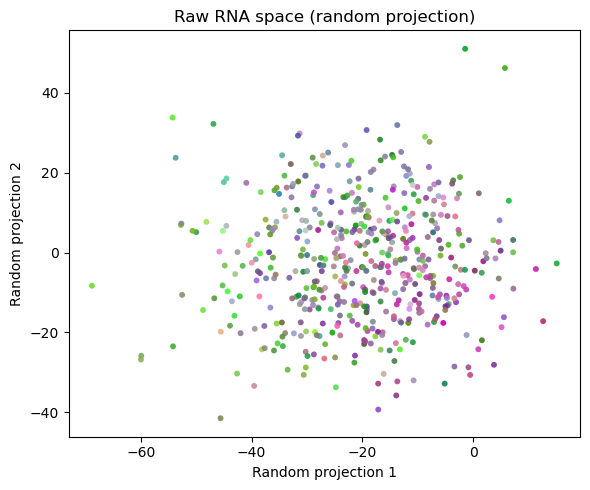

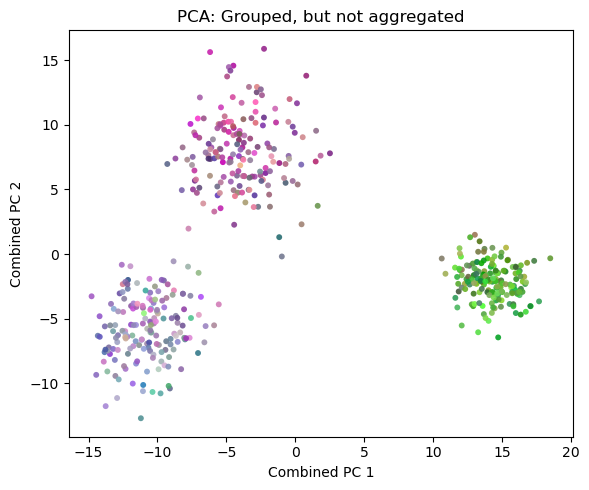

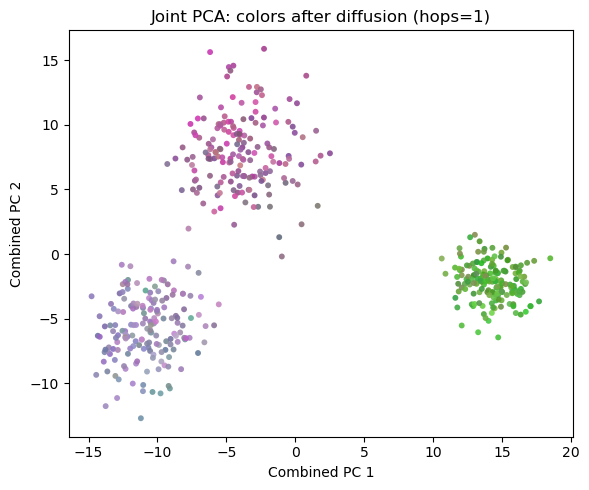

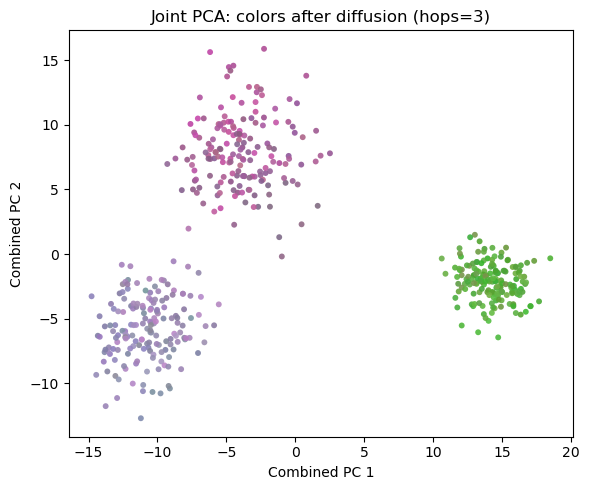

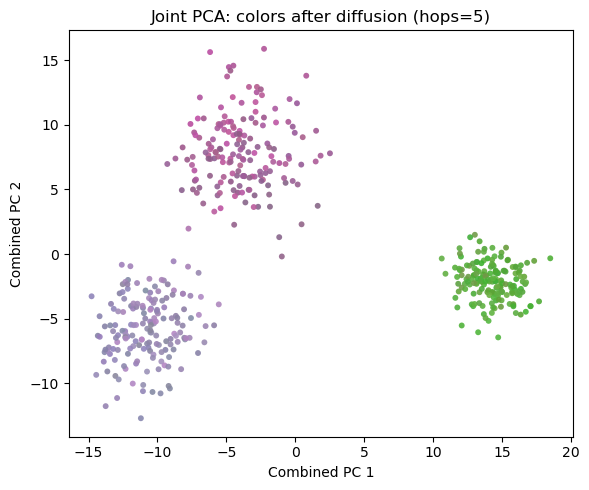

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_raw_random_projection(rna, rgb, title, seed=0):
    """
    Plot cells using a random 2D projection of raw RNA features.
    This intentionally does NOT learn structure.
    """
    rng = np.random.default_rng(seed)
    
    # Use raw log1p RNA (cells × genes)
    X = rna.layers["log1p"]
    if sp.issparse(X):
        X = X.toarray()
    
    # Random 2D projection
    R = rng.normal(size=(X.shape[1], 2))
    X2 = X @ R

    plt.figure(figsize=(6, 5))
    plt.scatter(X2[:, 0], X2[:, 1], c=rgb, s=18, alpha=0.9, linewidths=0)
    plt.title(title)
    plt.xlabel("Random projection 1")
    plt.ylabel("Random projection 2")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


def rgb_from_latent(Z, seed=0, noise=0.05):
    """
    Map latent vectors Z (cells×d) -> RGB (cells×3) via a random linear map,
    then squash to [0,1]. Nearby Z => similar colors.
    """
    rng = np.random.default_rng(seed)
    A = rng.normal(size=(Z.shape[1], 3))
    rgb = Z @ A
    rgb = (rgb - rgb.min(axis=0)) / (rgb.max(axis=0) - rgb.min(axis=0) + 1e-8)
    rgb = np.clip(rgb + rng.normal(0, noise, size=rgb.shape), 0, 1)
    return rgb.astype(np.float32)


def diffuse_rgb(W, rgb):
    """
    W: csr_matrix (n_cells x n_cells), row-stochastic
    rgb: (n_cells x 3)
    returns: (n_cells x 3)
    """
    rgb_h = W @ rgb  # weighted average of neighbor colors
    # numerical safety
    rgb_h = np.clip(np.asarray(rgb_h), 0.0, 1.0)
    return rgb_h

def plot_pca_colored(joint, rgb, title):
    X = joint.obsm["X_combined"]
    x1, x2 = X[:, 0], X[:, 1]
    plt.figure(figsize=(6, 5))
    plt.scatter(x1, x2, c=rgb, s=18, alpha=0.9, linewidths=0)
    plt.title(title)
    plt.xlabel("Combined PC 1")
    plt.ylabel("Combined PC 2")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def nearest_anchor_labels(rgb, anchors):
    """
    Assign each cell to nearest anchor in RGB space.
    rgb: (n_cells,3)
    anchors: (n_anchors,3)
    returns: labels (n_cells,), and anchor colors per cell (n_cells,3)
    """
    # squared Euclidean distance in RGB space
    d2 = ((rgb[:, None, :] - anchors[None, :, :]) ** 2).sum(axis=2)
    labels = d2.argmin(axis=1)
    snapped = anchors[labels]
    return labels, snapped

# 0) Make toy data + base joint coords (hops=1 is fine for plotting PCA coords)
rna, atac, Z = make_toy_multiome(n_cells=500, n_genes=500, n_peaks=800, n_clusters=3, seed=42)

# Use hops=1 joint for coordinates (PCA) so axes stay comparable across panels
joint_coords, W1 = build_joint_W(
    rna, atac,
    neighbors_k=10,
    pca_components=25,
    hops=1,
    self_weight=1.0
)

# 1) Random RGB per cell (this is the "signal" we will pseudo-bulk)
rgb0 = rgb_from_latent(Z, seed=123, noise=0.03)


plot_raw_random_projection(
    rna,
    rgb0,
    "Raw RNA space (random projection)"
)

plot_pca_colored(
    joint_coords,
    rgb0,
    "PCA: Grouped, but not aggregated"
)


# 2) Build W for multiple hops (same KNN graph, but different diffusion depth)
hop_list = [1, 3, 5]
Ws = {}
for h in hop_list:
    _, Wh = build_joint_W(
        rna, atac,
        neighbors_k=10,
        pca_components=5,
        hops=h,
        self_weight=1.0
    )
    Ws[h] = Wh

# 4) Plot smoothed colors for each hop
for h in hop_list:
    rgb_h = diffuse_rgb(Ws[h], rgb0)
    plot_pca_colored(joint_coords, rgb_h, f"Joint PCA: colors after diffusion (hops={h})")


/tmp/ipykernel_418444/2942280315.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


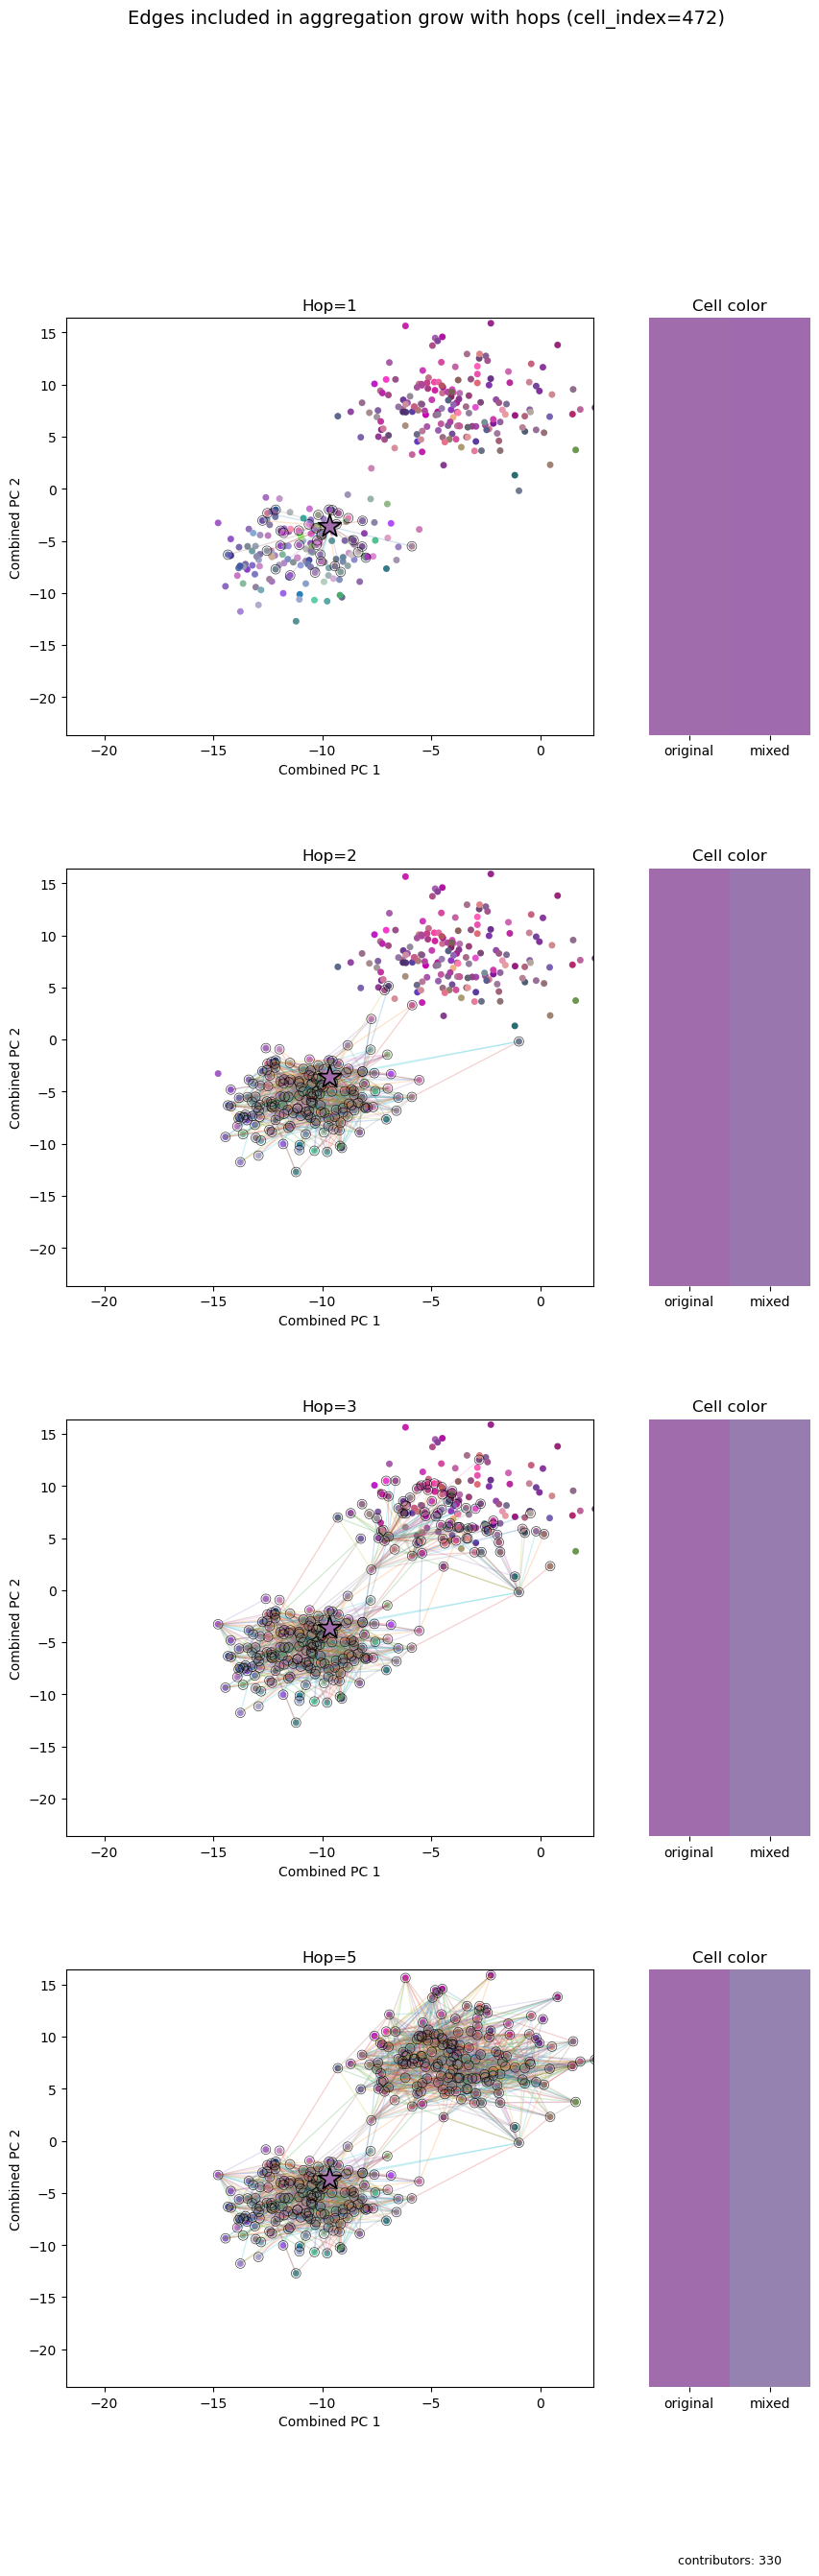

In [ ]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

def top_contributors(W: sp.csr_matrix, i: int, k: int = 12, drop_self: bool = True):
    row = W.getrow(i)
    idx = row.indices
    w = row.data.astype(float)

    if drop_self:
        m = idx != i
        idx, w = idx[m], w[m]

    if w.size == 0:
        return np.array([], dtype=int), np.array([], dtype=float)

    order = np.argsort(w)[::-1]
    idx, w = idx[order], w[order]

    # keep top-k and renormalize just for display clarity (optional)
    idx_k = idx[:k]
    w_k = w[:k]
    s = w_k.sum()
    if s > 0:
        w_k = w_k / s
    return idx_k, w_k

import numpy as np

def bfs_layers_and_edges(W1: sp.csr_matrix, start: int, max_hops: int):
    """
    BFS over the 1-hop graph W1 (treat as unweighted adjacency).
    Returns:
      layers[d] = set of nodes at exact distance d (d=0..max_hops)
      edges_by_depth[d] = list of (u,v) edges from depth d-1 -> depth d
    """
    layers = [set() for _ in range(max_hops + 1)]
    edges_by_depth = [[] for _ in range(max_hops + 1)]

    layers[0].add(start)
    visited = {start}

    frontier = {start}
    for d in range(1, max_hops + 1):
        next_frontier = set()
        for u in frontier:
            nbrs = W1.getrow(u).indices
            for v in nbrs:
                if v not in visited:
                    next_frontier.add(v)
        # record edges from previous frontier to newly discovered nodes
        for u in frontier:
            nbrs = W1.getrow(u).indices
            for v in nbrs:
                if v in next_frontier:
                    edges_by_depth[d].append((u, v))

        layers[d] = next_frontier
        visited |= next_frontier
        frontier = next_frontier

        if not frontier:
            break

    return layers, edges_by_depth

def contributing_nodes(W_h: sp.csr_matrix, i: int, weight_thresh: float = 0.0, drop_self=False):
    row = W_h.getrow(i)
    idx = row.indices
    w = row.data.astype(float)

    if drop_self:
        m = idx != i
        idx, w = idx[m], w[m]

    if weight_thresh > 0:
        m = w >= weight_thresh
        idx, w = idx[m], w[m]

    return idx, w


def compute_zoom_limits(x1, x2, center_i, neighbor_idx=None, pad_frac=0.25, min_span=None):
    """
    Compute x/y limits centered at cell `center_i`.
    If neighbor_idx is given, bounds are based on that neighborhood extent.
    Otherwise, use a default span based on overall data scale.

    pad_frac: add padding as a fraction of span.
    min_span: enforce a minimum span (in PCA units) so it never collapses.
    """
    cx, cy = x1[center_i], x2[center_i]

    if neighbor_idx is not None and len(neighbor_idx) > 0:
        xs = np.r_[cx, x1[neighbor_idx]]
        ys = np.r_[cy, x2[neighbor_idx]]
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
    else:
        # fallback: use a small window relative to overall spread
        x_span = np.std(x1) * 1.5
        y_span = np.std(x2) * 1.5
        x_min, x_max = cx - x_span/2, cx + x_span/2
        y_min, y_max = cy - y_span/2, cy + y_span/2

    x_span = x_max - x_min
    y_span = y_max - y_min

    if min_span is not None:
        x_span = max(x_span, min_span)
        y_span = max(y_span, min_span)

    # pad
    x_pad = x_span * pad_frac
    y_pad = y_span * pad_frac

    return (cx - x_span/2 - x_pad, cx + x_span/2 + x_pad,
            cy - y_span/2 - y_pad, cy + y_span/2 + y_pad)

def two_hop_edges(W: sp.csr_matrix, center_i: int, nbr_idx: np.ndarray, per_neighbor_k: int = 5):
    """
    Return list of (u,v) edges from each neighbor u in nbr_idx to its top-k neighbors v.
    """
    edges = []
    for u in nbr_idx:
        u_idx, _ = top_contributors(W, u, k=per_neighbor_k, drop_self=True)
        for v in u_idx:
            edges.append((u, v))
    return edges

def plot_cell_mixing_story_hop_edges(
    joint_coords,
    Ws_by_hop: dict,   # {h: W^h}
    W1: sp.csr_matrix, # base 1-hop graph (row-stochastic connectivities w/ self-loop)
    rgb0: np.ndarray,
    cell_index: int = None,
    hops_list=(1, 2, 3, 5),
    seed=0,
    weight_thresh=0.0,     # set e.g. 1e-4 if plots get too dense
    max_edges_per_depth=None,  # e.g. 3000 to cap drawing; None = draw all
    # visuals
    fig_w=10,
    row_h=7,
    bg_s=25,
    bg_alpha=1,
    star_s=320,
    contrib_s=50,
    edge_alpha=0.22,
    lw=0.9,
    pad_frac=0.2,
    min_span=1.0,
):
    X = joint_coords.obsm["X_combined"]
    x1, x2 = X[:, 0], X[:, 1]
    n = X.shape[0]

    rng = np.random.default_rng(seed)
    if cell_index is None:
        cell_index = int(rng.integers(0, n))

    c0 = rgb0[cell_index]

    nrows = len(hops_list)
    fig = plt.figure(figsize=(fig_w, row_h * nrows))
    gs = fig.add_gridspec(nrows, 2, width_ratios=[1.8, 0.55], wspace=0.16, hspace=0.32)

    # Precompute BFS layers/edges up to max hop once
    max_h = int(max(hops_list))
    layers, edges_by_depth = bfs_layers_and_edges(W1, cell_index, max_hops=max_h)

    # For consistent zoom, use all nodes reachable up to max hop (or contributors at max hop)
    all_reachable = set().union(*layers)
    all_reachable = np.array(sorted(all_reachable), dtype=int)
    fixed_limits = compute_zoom_limits(
        x1, x2, center_i=cell_index, neighbor_idx=all_reachable,
        pad_frac=pad_frac, min_span=min_span
    )

    for r, h in enumerate(hops_list):
        W_h = Ws_by_hop[h]

        # mixed color
        ch = np.asarray(W_h.getrow(cell_index) @ rgb0).ravel()
        ch = np.clip(ch, 0, 1)

        # contributing nodes at this hop from W^h row
        contrib_idx, contrib_w = contributing_nodes(W_h, cell_index, weight_thresh=weight_thresh, drop_self=True)
        contrib_set = set(contrib_idx.tolist())

        # collect edges up to depth h (Hop 1 only depth-1 edges, Hop 2 includes depth-2, etc.)
        edges_to_draw = []
        for d in range(1, int(h) + 1):
            edges_to_draw.extend(edges_by_depth[d])

        # optional: cap edges for readability, but still faithful-ish
        if max_edges_per_depth is not None and len(edges_to_draw) > max_edges_per_depth:
            edges_to_draw = edges_to_draw[:max_edges_per_depth]

        ax0 = fig.add_subplot(gs[r, 0])
        ax0.scatter(x1, x2, s=bg_s, c=rgb0, alpha=bg_alpha, linewidths=0)

        # draw hop-expansion edges
        for u, v in edges_to_draw:
            ax0.plot([x1[u], x1[v]], [x2[u], x2[v]], alpha=edge_alpha, linewidth=lw, zorder=1)

        # highlight contributors at hop h (circled)
        if contrib_idx.size > 0:
            ax0.scatter(x1[contrib_idx], x2[contrib_idx],
                        s=contrib_s, facecolors="none", edgecolors="k",
                        linewidths=0.5, alpha=0.75, zorder=4)

        # star the selected cell
        ax0.scatter([x1[cell_index]], [x2[cell_index]],
                    s=star_s, marker="*", c=[c0],
                    edgecolors="k", linewidths=1.2, zorder=5)

        xmin, xmax, ymin, ymax = fixed_limits
        ax0.set_xlim(xmin, xmax)
        ax0.set_ylim(ymin, ymax)
        ax0.set_title(f"Hop={h}", fontsize=12)
        ax0.set_xlabel("Combined PC 1")
        ax0.set_ylabel("Combined PC 2")
        ax0.grid(False)

        # color strip
        ax1 = fig.add_subplot(gs[r, 1])
        strip = np.stack([c0, ch], axis=0)[None, :, :]
        ax1.imshow(strip, aspect="auto")
        ax1.set_yticks([])
        ax1.set_xticks([0, 1])
        ax1.set_xticklabels(["original", f"mixed"], fontsize=10)
        ax1.set_title("Cell color", fontsize=12)
        for spine in ax1.spines.values():
            spine.set_visible(False)

        # tiny stat: how many contributors at this hop
        ax1.text(0.5, -0.40, f"contributors: {len(contrib_idx)}",
                 ha="center", va="top", transform=ax1.transAxes, fontsize=9)

    fig.suptitle(f"Edges included in aggregation grow with hops (cell_index={cell_index})", y=0.995, fontsize=14)
    plt.tight_layout()
    plt.show()
    return cell_index


hops_list = [1, 2, 3, 5]
Ws = {h: build_joint_W(rna, atac, neighbors_k=20, pca_components=25, hops=h, self_weight=1.0)[1] for h in hops_list}
W1 = Ws[1]

cell_index = plot_cell_mixing_story_hop_edges(
    joint_coords=joint_coords,
    Ws_by_hop=Ws,
    W1=W1,
    rgb0=rgb0,
    hops_list=hops_list,
    seed=7,
    weight_thresh=0.0,     # if too dense, try 1e-4 or 5e-4
    max_edges_per_depth=None,  # set e.g. 4000 if you need a cap
)


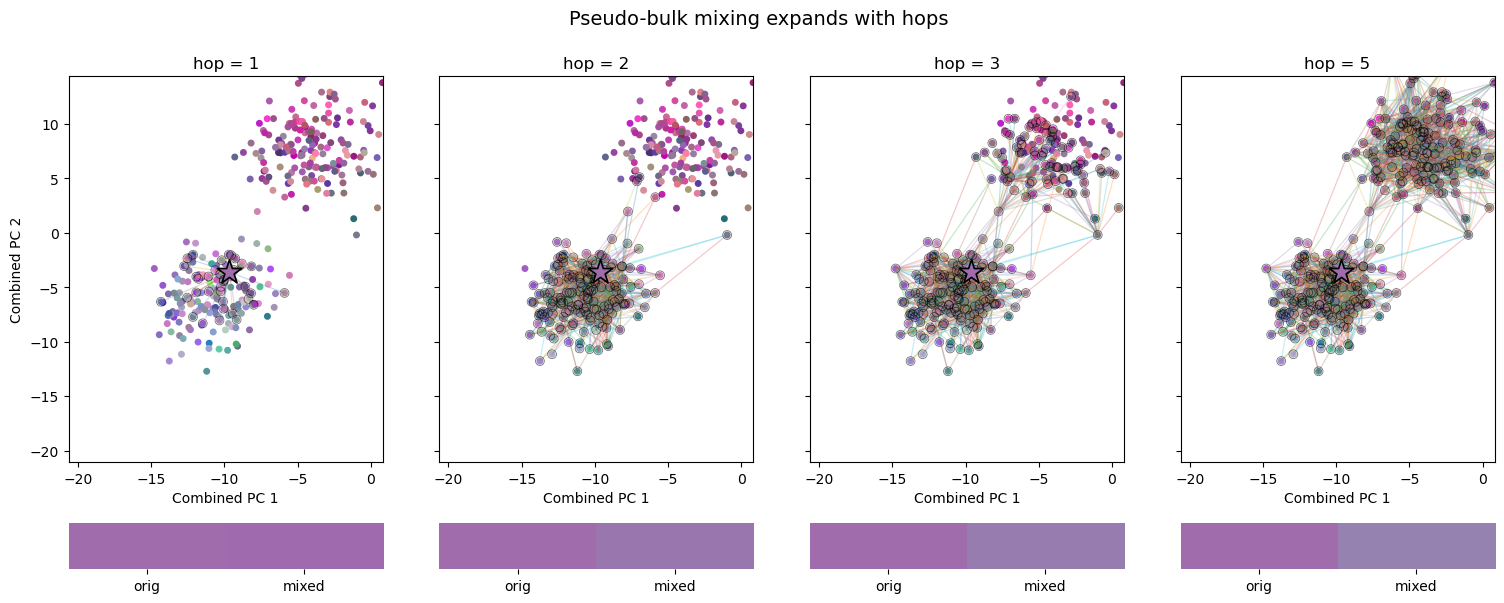

In [50]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

# -----------------------------
# Helpers (same as yours)
# -----------------------------
def bfs_layers_and_edges(W1: sp.csr_matrix, start: int, max_hops: int):
    layers = [set() for _ in range(max_hops + 1)]
    edges_by_depth = [[] for _ in range(max_hops + 1)]

    layers[0].add(start)
    visited = {start}
    frontier = {start}

    for d in range(1, max_hops + 1):
        next_frontier = set()
        for u in frontier:
            for v in W1.getrow(u).indices:
                if v not in visited:
                    next_frontier.add(v)

        # record depth edges: frontier -> next_frontier
        for u in frontier:
            nbrs = W1.getrow(u).indices
            for v in nbrs:
                if v in next_frontier:
                    edges_by_depth[d].append((u, v))

        layers[d] = next_frontier
        visited |= next_frontier
        frontier = next_frontier
        if not frontier:
            break

    return layers, edges_by_depth


def contributing_nodes(W_h: sp.csr_matrix, i: int, weight_thresh: float = 0.0, drop_self=False):
    row = W_h.getrow(i)
    idx = row.indices
    w = row.data.astype(float)

    if drop_self:
        m = idx != i
        idx, w = idx[m], w[m]

    if weight_thresh > 0:
        m = w >= weight_thresh
        idx, w = idx[m], w[m]

    return idx, w


def compute_zoom_limits(
    x1, x2, center_i,
    neighbor_idx=None,
    pad_frac=0.25,
    min_span=None,
    offset=(0.0, 0.0),  # NEW
):
    cx, cy = x1[center_i], x2[center_i]
    ox, oy = offset

    if neighbor_idx is not None and len(neighbor_idx) > 0:
        xs = np.r_[cx, x1[neighbor_idx]]
        ys = np.r_[cy, x2[neighbor_idx]]
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
    else:
        x_span = np.std(x1) * 1.5
        y_span = np.std(x2) * 1.5
        x_min, x_max = cx - x_span/2, cx + x_span/2
        y_min, y_max = cy - y_span/2, cy + y_span/2

    x_span = max(x_max - x_min, min_span or 0)
    y_span = max(y_max - y_min, min_span or 0)

    x_pad = x_span * pad_frac
    y_pad = y_span * pad_frac

    cx += ox
    cy += oy

    return (
        cx - x_span/2 - x_pad,
        cx + x_span/2 + x_pad,
        cy - y_span/2 - y_pad,
        cy + y_span/2 + y_pad,
    )


def plot_cell_mixing_story_columns(
    joint_coords,
    Ws_by_hop: dict,   # {h: W^h}
    W1: sp.csr_matrix, # base 1-hop graph
    rgb0: np.ndarray,
    cell_index: int = None,
    hops_list=(1, 2, 3, 5),
    seed=0,
    weight_thresh=0.0,
    max_edges_per_hop=None,
    # ---- VISUAL TUNING ----
    fig_w_per_col=4.6,
    fig_h=6.4,
    bg_s=25,
    bg_alpha=1,
    star_s=340,
    contrib_s=40,          # ↓ smaller circles
    contrib_alpha=0.55,    # ↓ lower alpha
    fill_s=110,            # ↑ larger filled points
    fill_alpha=0,       # ↑ higher alpha
    edge_alpha=0.25,
    lw=0.9,
    pad_frac=0.12,         # ↓ tighter zoom
    min_span=0.7,          # ↓ zoom further in
):
    X = joint_coords.obsm["X_combined"]
    x1, x2 = X[:, 0], X[:, 1]
    n = X.shape[0]

    rng = np.random.default_rng(seed)
    if cell_index is None:
        cell_index = int(rng.integers(0, n))

    c0 = rgb0[cell_index]
    hops_list = list(hops_list)
    ncols = len(hops_list)

    # BFS on base graph
    max_h = int(max(hops_list))
    layers, edges_by_depth = bfs_layers_and_edges(W1, cell_index, max_hops=max_h)

    all_reachable = set().union(*layers)
    all_reachable = np.array(sorted(all_reachable), dtype=int)
    fixed_limits = compute_zoom_limits(
        x1, x2,
        center_i=cell_index,
        neighbor_idx=all_reachable,
        pad_frac=0.12,
        min_span=0.7,
        offset=(-0.25, 0.25)  # ← left + down
    )
    xmin, xmax, ymin, ymax = fixed_limits

    # ---- Layout: more vertical separation ----
    fig = plt.figure(figsize=(fig_w_per_col * ncols, fig_h))
    gs = fig.add_gridspec(
        2, ncols,
        height_ratios=[1.0, 0.12],   # thinner color bar row
        wspace=0.18,
        hspace=0.28                  # push color bars downward
    )

    for c, h in enumerate(hops_list):
        W_h = Ws_by_hop[h]

        # Mixed color
        ch = np.asarray(W_h.getrow(cell_index) @ rgb0).ravel()
        ch = np.clip(ch, 0, 1)

        contrib_idx, _ = contributing_nodes(
            W_h, cell_index, weight_thresh=weight_thresh, drop_self=True
        )

        # edges up to hop h
        edges_to_draw = []
        for d in range(1, int(h) + 1):
            edges_to_draw.extend(edges_by_depth[d])

        if max_edges_per_hop is not None and len(edges_to_draw) > max_edges_per_hop:
            edges_to_draw = edges_to_draw[:max_edges_per_hop]

        # ---------- MAIN PANEL ----------
        ax = fig.add_subplot(gs[0, c])
        ax.scatter(x1, x2, s=bg_s, c=rgb0, alpha=bg_alpha, linewidths=0, zorder=0)

        for u, v in edges_to_draw:
            ax.plot([x1[u], x1[v]], [x2[u], x2[v]],
                    alpha=edge_alpha, linewidth=lw, zorder=1)

        # contributors (filled)
        if contrib_idx.size > 0:
            ax.scatter(
                x1[contrib_idx], x2[contrib_idx],
                s=fill_s,
                c=rgb0[contrib_idx],
                alpha=fill_alpha,
                linewidths=0,
                zorder=3
            )

            # contributor circles (smaller + lighter)
            ax.scatter(
                x1[contrib_idx], x2[contrib_idx],
                s=contrib_s,
                facecolors="none",
                edgecolors="k",
                linewidths=0.6,
                alpha=contrib_alpha,
                zorder=4
            )

        # selected cell
        ax.scatter(
            [x1[cell_index]], [x2[cell_index]],
            s=star_s, marker="*", c=[c0],
            edgecolors="k", linewidths=1.2, zorder=5
        )

        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title(f"hop = {h}", fontsize=12)
        ax.set_xlabel("Combined PC 1")
        if c == 0:
            ax.set_ylabel("Combined PC 2")
        else:
            ax.set_yticklabels([])
        ax.grid(False)

        # ---------- COLOR BAR ----------
        axc = fig.add_subplot(gs[1, c])
        strip = np.stack([c0, ch], axis=0)[None, :, :]
        axc.imshow(strip, aspect="auto")
        axc.set_yticks([])
        axc.set_xticks([0, 1])
        axc.set_xticklabels(["orig", "mixed"], fontsize=10)
        for spine in axc.spines.values():
            spine.set_visible(False)

    fig.suptitle(
        f"Pseudo-bulk mixing expands with hops",
        y=0.985,
        fontsize=14
    )
    plt.show()
    return cell_index



# Example call (as before)
hops_list = [1, 2, 3, 5]
Ws = {h: build_joint_W(rna, atac, neighbors_k=20, pca_components=25, hops=h, self_weight=1.0)[1] for h in hops_list}
W1 = Ws[1]

cell_index = plot_cell_mixing_story_columns(
    joint_coords=joint_coords,
    Ws_by_hop=Ws,
    W1=W1,
    rgb0=rgb0,
    hops_list=hops_list,
    seed=7,
    weight_thresh=0.0,      # try 1e-4 if you want fewer circled nodes
    max_edges_per_hop=None, # try e.g. 4000 if plots get too dense
)
